# Driver and engine performance impact on F1 race results

Łukasz Filo, Klaudiusz Grobelski

## Problem formulation [0-5 pts]:

- is the problem clearly stated [1 pt]
- what is the point of creating model, are potential use cases defined [1 pt]
- where do data comes from, what does it containt [1 pt]
- DAG has been drawn [1 pt]
- confoundings (pipe, fork, collider) were described [1 pt]

In this notebook, we will develop a Bayesian multilevel binomial regression model to predict driver performance across recent Formula 1 seasons. Specifically, we will use data from the 2019–2024 seasons. The input data includes information about drivers, constructors, and engine suppliers used by each team. The primary objective of this analysis is to understand and predict how various factors—such as driver skill, team changes, and engine suppliers—affect driver performance over time. This model could assist teams in making strategic decisions, such as evaluating whether changes in drivers or engine suppliers might enhance performance. It may also be valuable to fans and analysts seeking to assess the relative impact of technical and human factors on race results.

We use historical race data sourced from FastF1, which includes finishing positions, lap times, and team-driver pairings for each race. Driver skill ratings are obtained from the EA Sports F1 game, while engine usage data (i.e., which power unit each constructor used in a given season) is collected from Wikipedia, covering the 2019–2024 period.

To gain a clearer understanding of the relationships between variables and to identify potential sources of bias, we will construct a Directed Acyclic Graph (DAG). The DAG will include nodes such as Driver Skill, Team, Engine, and Performance, and will help visualize dependencies and causal paths within the data.

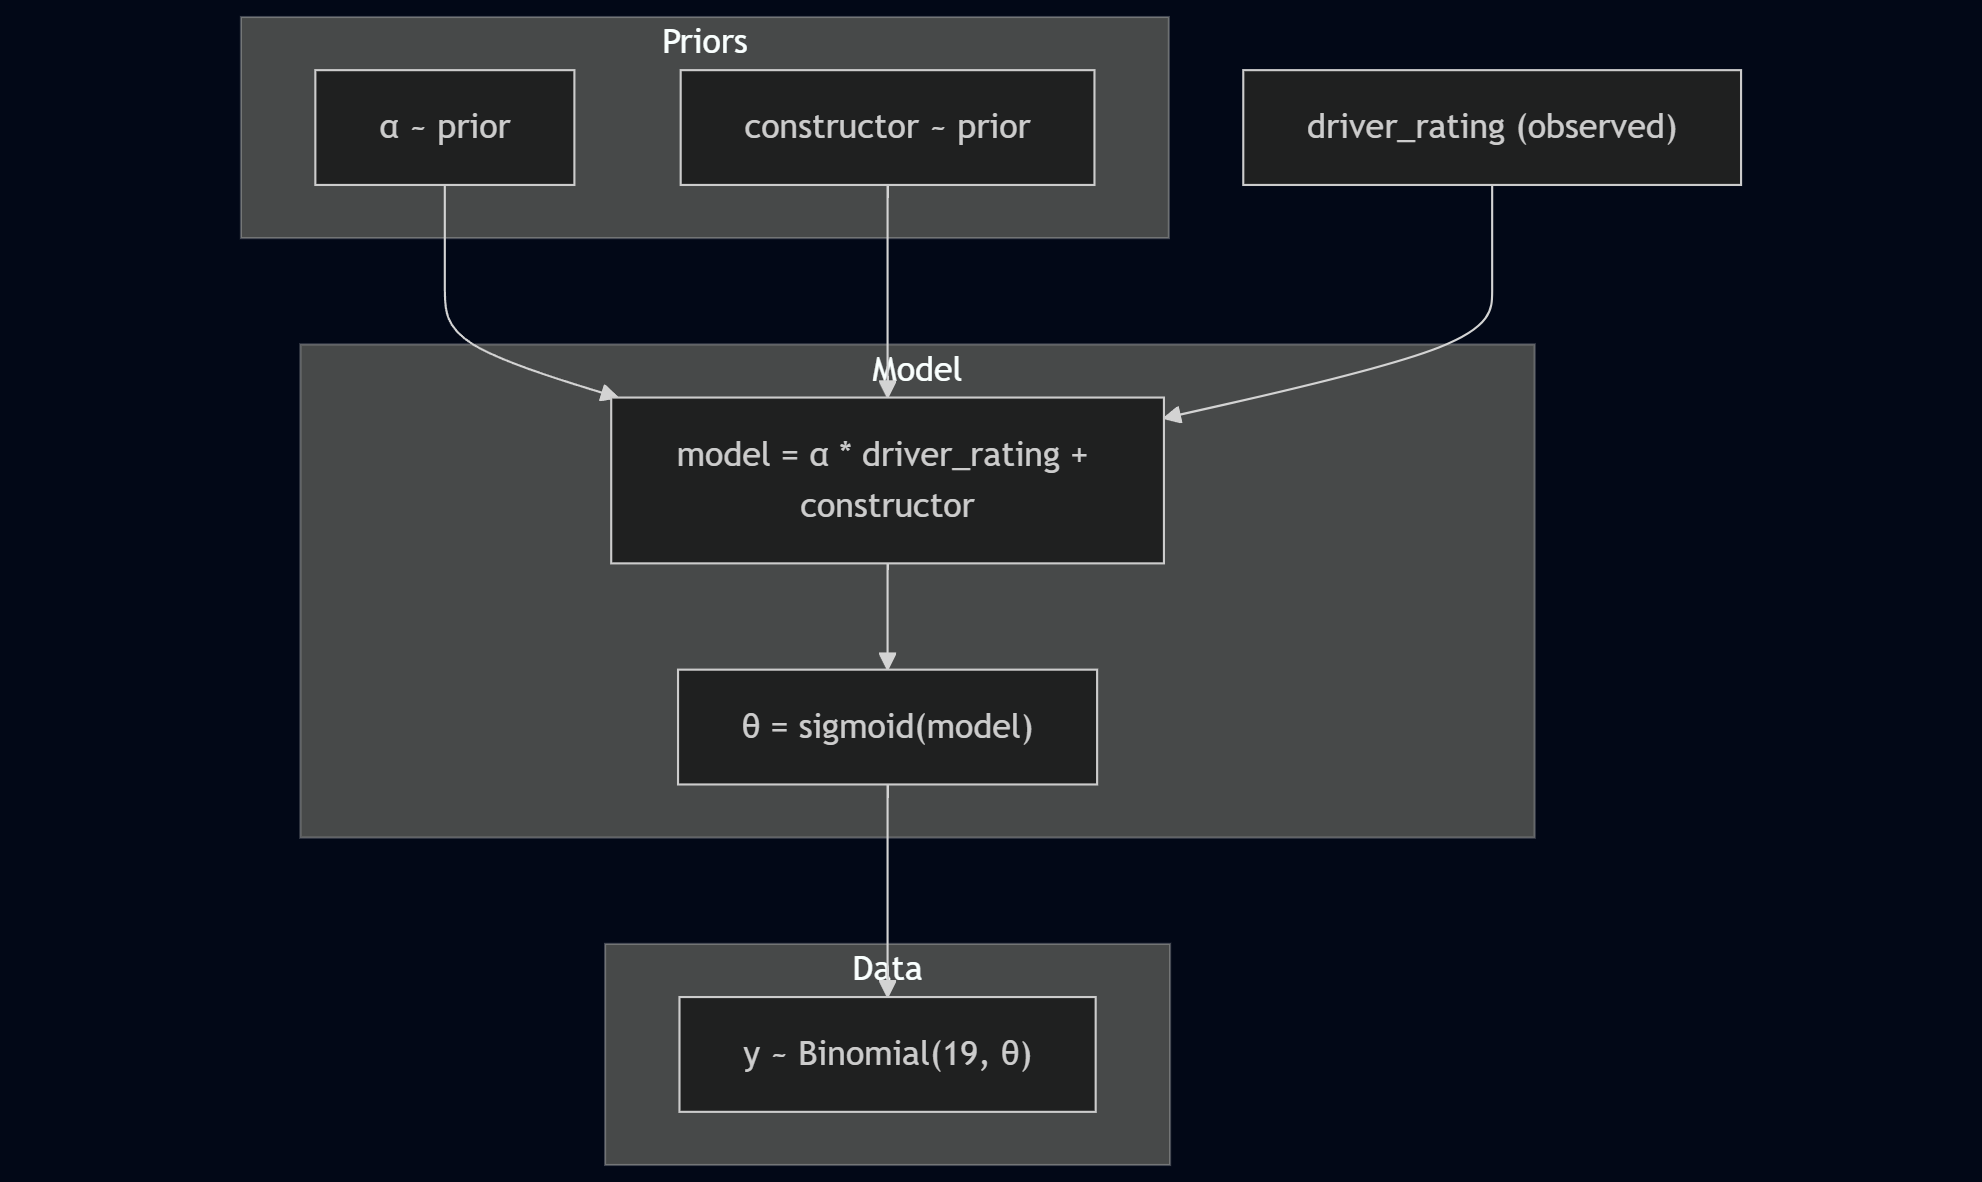

In [1]:
from IPython.display import Image
Image("images/model1_DAG.png")

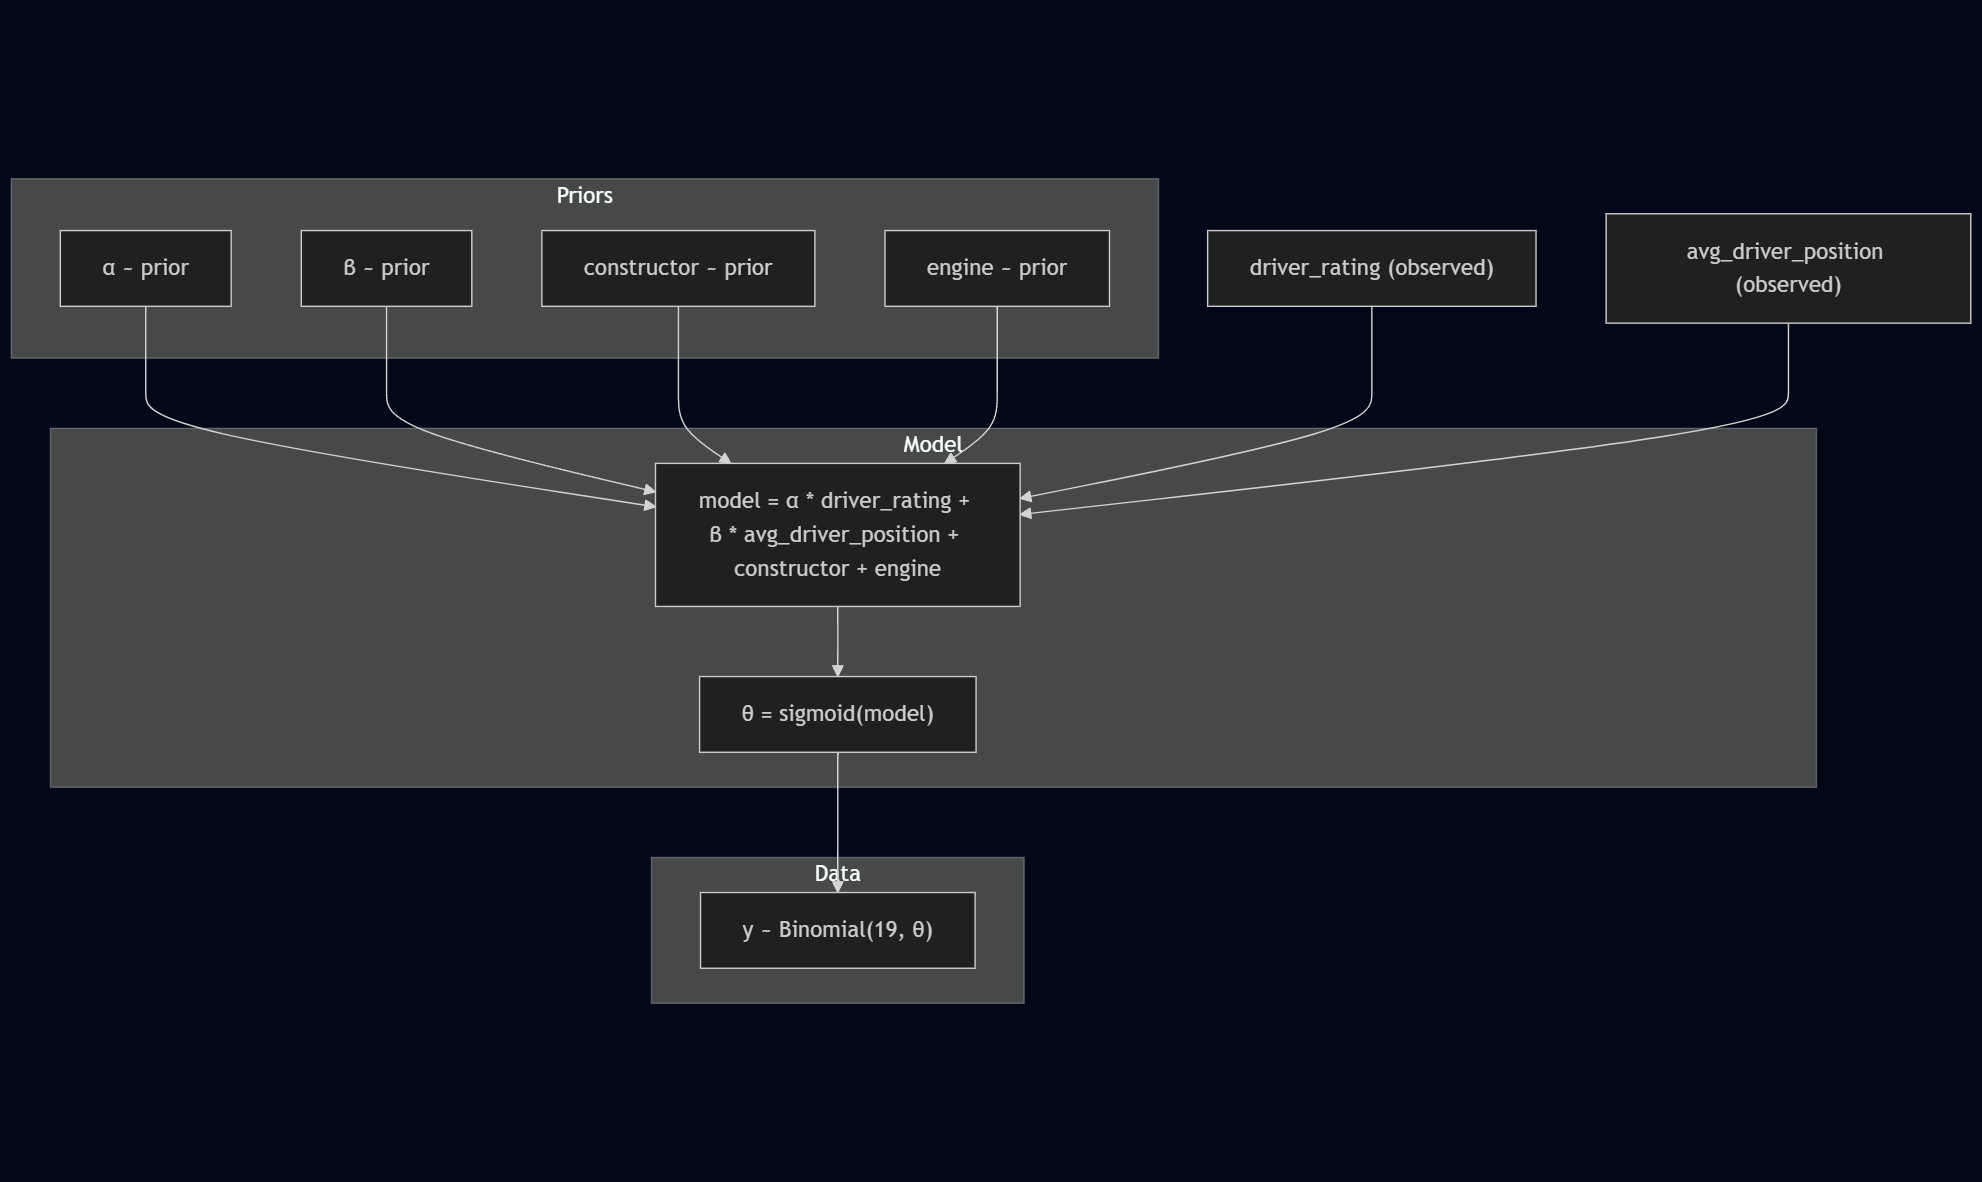

In [2]:
Image("images/model2_DAG.png")

DAGs illustrate the main types of confounding structures:

 - Forks: Present in both models where multiple variables (e.g., `α`, `constructor`, `β`, `engine`) influence the same downstream node (the linear model).

- Pipes: Clear in the chain `model` → `θ` → `y`, representing a direct causal path.

In [3]:
import numpy as np
from cmdstanpy import CmdStanModel
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Data preprocessing [0-2 pts]:
- is preprocessing step clearly described [1 pt]
- reasoning and types of actions taken on the dataset have been described [1 pt]

## Model [0-4 pts]
- are two different models specified [1 pt]
- are difference between two models explained [1 pt]
- is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt]
- are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]

$ y \sim \mathcal{Binomial}(19, \theta)$
### Model 1: Yearly driver rating and team performace.

## Priors [0-4 pts]
- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

## Posterior analysis (model 1) [0-4 pts]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

## Posterior analysis (model 2) [0-4 pts]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
 are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

## Model comaprison [0-4 pts]
- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]